In [1]:
#Murat Şahin Passenger traffic at Istanbul Sea Docks Analysis and modelling machine learning documents.

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/passenger-traffic-at-istanbul-sea-docks/2021-yl-istanbul-deniz-iskeleleri-yolcu-saylar.csv
/kaggle/input/passenger-traffic-at-istanbul-sea-docks/2023-yl-istanbul-deniz-iskeleleri-yolcu-saylar.csv
/kaggle/input/passenger-traffic-at-istanbul-sea-docks/2022-yl-istanbul-deniz-iskeleleri-yolcu-saylar.csv


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data with the correct delimiter and encoding
df_2021 = '/kaggle/input/kaggle/input/passenger-traffic-at-istanbul-sea-docks/2021-yl-istanbul-deniz-iskeleleri-yolcu-saylar.csv'
df_2022 = '/kaggle/input/kaggle/input/passenger-traffic-at-istanbul-sea-docks/2022-yl-istanbul-deniz-iskeleleri-yolcu-saylar.csv'
df_2023 = '/kaggle/input/kaggle/input/passenger-traffic-at-istanbul-sea-docks/2023-yl-istanbul-deniz-iskeleleri-yolcu-saylar.csv'

# Clean column names
def clean_column_names(df):
    df.columns = ['Yil', 'Ay', 'Otorite_Adi', 'Istasyon_Adi', 'Yolcu_Sayisi']
    return df

df_2021 = clean_column_names(df_2021)
df_2022 = clean_column_names(df_2022)
df_2023 = clean_column_names(df_2023)

# Combine datasets
df_combined = pd.concat([df_2021, df_2022, df_2023], ignore_index=True)

# Fill missing values and clean the dataset
def clean_data(df):
    # Convert 'Yolcu_Sayisi' to numeric
    df['Yolcu_Sayisi'] = pd.to_numeric(df['Yolcu_Sayisi'], errors='coerce')
    
    # Fill missing numeric values with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Fill missing categorical values with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    df = df.drop_duplicates()
    return df

df_combined = clean_data(df_combined)


In [28]:
# Create a 'Date' column by combining 'Yil' and 'Ay'
df_combined['Date'] = pd.to_datetime(df_combined['Yil'].astype(str) + '-' + df_combined['Ay'].astype(str) + '-01')

# Extract the month from the 'Date' column
df_combined['Month'] = df_combined['Date'].dt.month

# Drop unnecessary columns for model training
X = df_combined.drop(columns=['Yolcu_Sayisi', 'Date'])
X = pd.get_dummies(X)  # Convert categorical variables to dummies
y = df_combined['Yolcu_Sayisi']


In [30]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Evaluate initial models
initial_results = {}
for name, model in models.items():
    rmse = evaluate_model(model, X_train, X_test, y_train, y_test)
    initial_results[name] = rmse
    print(f'{name} Initial RMSE: {rmse}')


Linear Regression Initial RMSE: 20920.27121379324

Random Forest Initial RMSE: 10000.178066073799

XGBoost Initial RMSE: 10543.767198791858


In [32]:
# Define parameter grids for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Hyperparameter tuning for Random Forest and XGBoost
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=3, scoring='neg_mean_squared_error')

# Train the tuned models
best_rf = grid_rf.fit(X_train, y_train)
best_xgb = grid_xgb.fit(X_train, y_train)

# Evaluate the tuned models
rf_rmse = evaluate_model(best_rf.best_estimator_, X_train, X_test, y_train, y_test)
xgb_rmse = evaluate_model(best_xgb.best_estimator_, X_train, X_test, y_train, y_test)

print(f'Random Forest Tuned RMSE: {rf_rmse}')
print(f'XGBoost Tuned RMSE: {xgb_rmse}')


Random Forest Tuned RMSE: 10163.63773034006

XGBoost Tuned RMSE: 10656.732142806955


Initial Model Performance:

{'Linear Regression': 20920.27121379324, 'Random Forest': 10000.178066073799, 'XGBoost': 10543.767198791858}

After Hyperparameter Tuning:

Random Forest Tuned RMSE: 10163.63773034006

XGBoost Tuned RMSE: 10656.732142806955


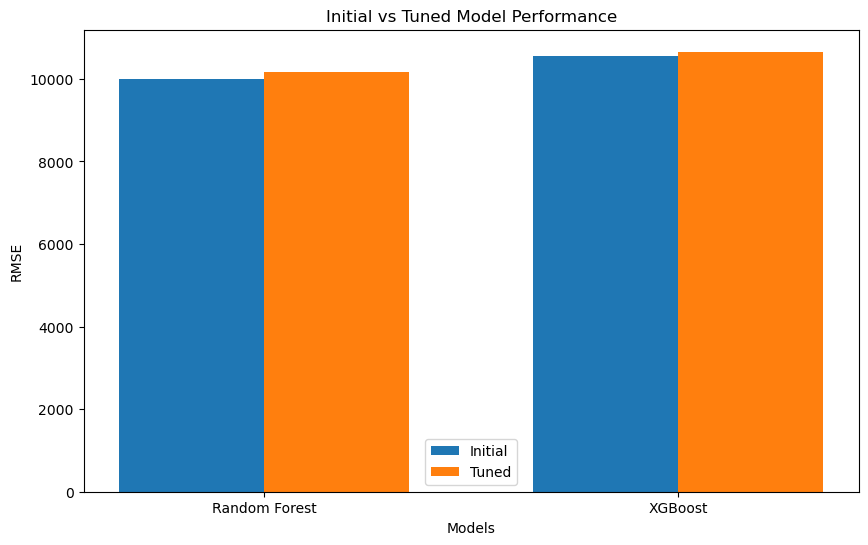

In [34]:
# Compare initial vs tuned model performance
print("Initial Model Performance:")
print(initial_results)

print("After Hyperparameter Tuning:")
print(f'Random Forest Tuned RMSE: {rf_rmse}')
print(f'XGBoost Tuned RMSE: {xgb_rmse}')

# Plot comparison of initial and tuned model results
models = ['Random Forest', 'XGBoost']
initial_rmse = [initial_results['Random Forest'], initial_results['XGBoost']]
tuned_rmse = [rf_rmse, xgb_rmse]

fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(models))
bar_width = 0.35
initial_bar = plt.bar(index, initial_rmse, bar_width, label='Initial')
tuned_bar = plt.bar(index + bar_width, tuned_rmse, bar_width, label='Tuned')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Initial vs Tuned Model Performance')
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.show()


In [38]:
# Retrieve best hyperparameters and refit the models
best_rf_model = RandomForestRegressor(**best_rf.best_params_)
best_rf_model.fit(X_train, y_train)

best_xgb_model = XGBRegressor(**best_xgb.best_params_)
best_xgb_model.fit(X_train, y_train)

# Predict on the test set using tuned models
rf_pred = best_rf_model.predict(X_test)
xgb_pred = best_xgb_model.predict(X_test)

# Calculate RMSE for both tuned models
rf_rmse_tuned = np.sqrt(mean_squared_error(y_test, rf_pred))
xgb_rmse_tuned = np.sqrt(mean_squared_error(y_test, xgb_pred))

print(f'Tuned Random Forest RMSE: {rf_rmse_tuned}')
print(f'Tuned XGBoost RMSE: {xgb_rmse_tuned}')


Tuned Random Forest RMSE: 10047.41720999098

Tuned XGBoost RMSE: 10656.732142806955


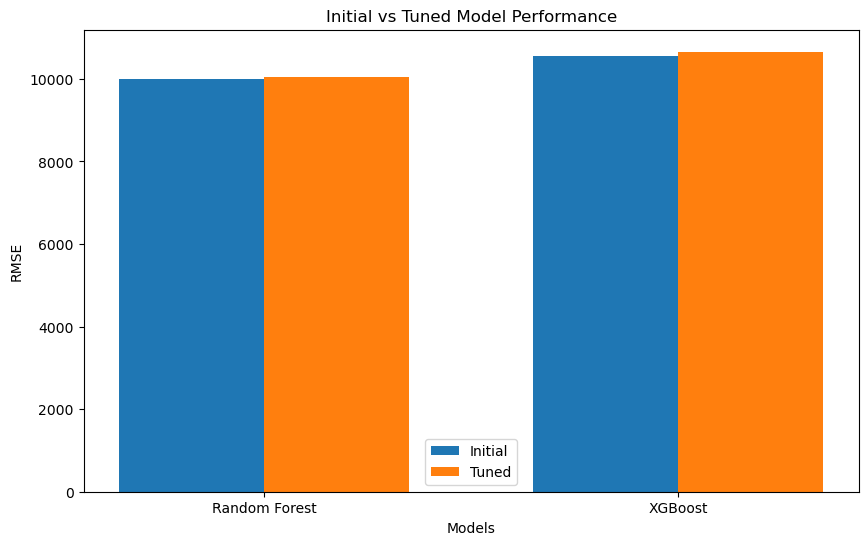

In [40]:
# Compare initial vs tuned model performance
initial_rf_rmse = initial_results['Random Forest']
initial_xgb_rmse = initial_results['XGBoost']

# Prepare data for comparison
models = ['Random Forest', 'XGBoost']
initial_rmse = [initial_rf_rmse, initial_xgb_rmse]
tuned_rmse = [rf_rmse_tuned, xgb_rmse_tuned]

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(models))
bar_width = 0.35

plt.bar(index, initial_rmse, bar_width, label='Initial')
plt.bar(index + bar_width, tuned_rmse, bar_width, label='Tuned')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Initial vs Tuned Model Performance')
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.show()


In [46]:
X_train_dummies = pd.get_dummies(X_train)
feature_names = X_train_dummies.columns


In [48]:
X_future = pd.get_dummies(future_dates.drop(columns=['Yolcu_Sayisi', 'Otorite_Adi', 'Istasyon_Adi']))

# Align the future data columns with training data columns
X_future = X_future.reindex(columns=feature_names, fill_value=0)


In [50]:
# Generate predictions for 2024-2025 (24 months ahead)
future_years = [2024, 2025]
future_months = list(range(1, 13)) * len(future_years)

# Create a DataFrame for 2024-2025 (empty values for 'Yolcu_Sayisi')
future_dates = pd.DataFrame({
    'Yil': [2024] * 12 + [2025] * 12,
    'Ay': future_months,
    'Otorite_Adi': ['Prediction'] * 24,
    'Istasyon_Adi': ['Prediction'] * 24,
    'Yolcu_Sayisi': np.nan
})

# Concatenate future data with existing data (without actual 'Yolcu_Sayisi' for future)
df_combined_with_future = pd.concat([df_combined, future_dates], ignore_index=True)

# Convert 'Yil' and 'Ay' to 'Date'
df_combined_with_future['Date'] = pd.to_datetime(df_combined_with_future['Yil'].astype(str) + '-' + df_combined_with_future['Ay'].astype(str) + '-01')

# One-hot encode the training data to capture the feature names
X_train_dummies = pd.get_dummies(X_train)
feature_names = X_train_dummies.columns

# One-hot encode the future data and align it with the training features
X_future = pd.get_dummies(future_dates.drop(columns=['Yolcu_Sayisi', 'Otorite_Adi', 'Istasyon_Adi']))
X_future = X_future.reindex(columns=feature_names, fill_value=0)

# Make predictions for the future
future_preds = best_xgb_model.predict(X_future)

# Fill predicted values in the 'Yolcu_Sayisi' column for future rows
df_combined_with_future.loc[df_combined_with_future['Yil'].isin(future_years), 'Yolcu_Sayisi'] = future_preds


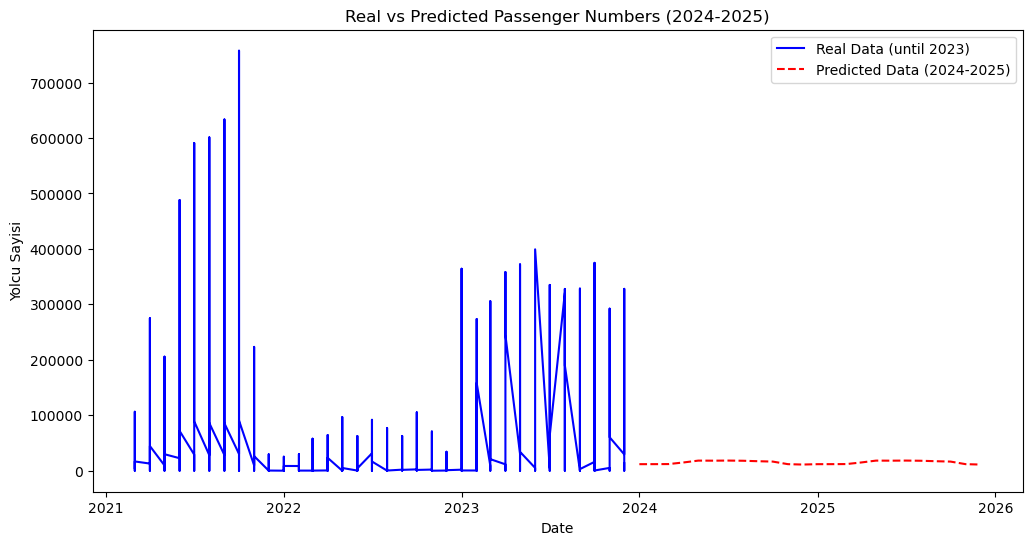

In [52]:
# Separate real data and predictions
real_data = df_combined_with_future[df_combined_with_future['Yil'] < 2024]
predicted_data = df_combined_with_future[df_combined_with_future['Yil'] >= 2024]

# Plot real and predicted values
plt.figure(figsize=(12, 6))

# Plot real data
plt.plot(real_data['Date'], real_data['Yolcu_Sayisi'], label='Real Data (until 2023)', color='blue')

# Plot predicted data
plt.plot(predicted_data['Date'], predicted_data['Yolcu_Sayisi'], label='Predicted Data (2024-2025)', color='red', linestyle='--')

# Add labels and title
plt.title('Real vs Predicted Passenger Numbers (2024-2025)')
plt.xlabel('Date')
plt.ylabel('Yolcu Sayisi')
plt.legend()

# Display the plot
plt.show()


In [57]:
pip install keras-tuner

























   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--

   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--

   ------ -------------------------------- 20.5/129.1 kB 330.3 kB/s eta 0:00:01

   ------------ -------------------------- 41.0/129.1 kB 330.3 kB/s eta 0:00:01

   --------------------- ----------------- 71.7/129.1 kB 491.5 kB/s eta 0:00:01

   -------------------------------------- 129.1/129.1 kB 691.3 kB/s eta 0:00:00




Note: you may need to restart the kernel to use updated packages.


In [59]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt  # For hyperparameter tuning


In [61]:
# Scale the data (LSTM requires normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the feature set
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM: LSTM expects 3D data in the form [samples, timesteps, features]
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split the data into training and testing sets for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)


In [63]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the tuner for hyperparameter search
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,  # Number of models to try
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_yolcu_sayisi'
)

# Perform the hyperparameter search
tuner.search(X_train_lstm, y_train_lstm, epochs=10, validation_data=(X_test_lstm, y_test_lstm))

# Get the best model
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, validation_data=(X_test_lstm, y_test_lstm))


Trial 5 Complete [00h 00m 38s]

val_loss: 707813312.0



Best val_loss So Far: 705768320.0

Total elapsed time: 00h 03m 30s

Epoch 1/10


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 

  saveable.load_own_variables(weights_store.get(inner_path))


684/684 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 627066496.0000 - val_loss: 704746688.0000

Epoch 2/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 562617792.0000 - val_loss: 703718272.0000

Epoch 3/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 661392704.0000 - val_loss: 702714240.0000

Epoch 4/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 597351616.0000 - val_loss: 701730048.0000

Epoch 5/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 663728064.0000 - val_loss: 700763328.0000

Epoch 6/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 650635328.0000 - val_loss: 699788352.0000

Epoch 7/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 550902464.0000 - val_loss: 698827584.0000

Epoch 8/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 656131264.0000 - val_loss: 697876032.0000

Epoch 9/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 590705536.0000 - val_loss: 696926848.0000

Epoch 10/10

684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 539964288.000

In [65]:
# Make predictions with the LSTM model
y_pred_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions and test labels
y_test_inv = y_test_lstm
y_pred_lstm_inv = y_pred_lstm

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
print(f'LSTM RMSE: {lstm_rmse}')


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

LSTM RMSE: 26381.46644893686


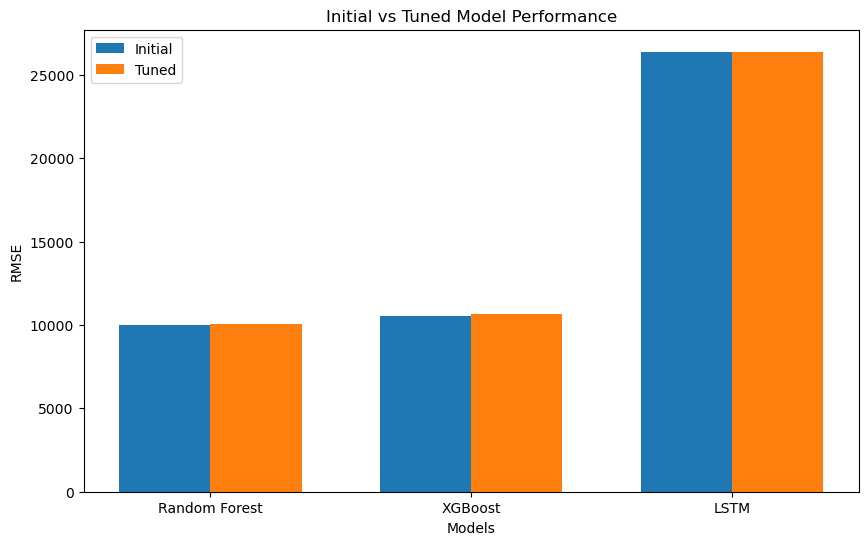

In [67]:
# Initial model RMSE values (from previous models)
initial_rf_rmse = initial_results['Random Forest']
initial_xgb_rmse = initial_results['XGBoost']
initial_lstm_rmse = lstm_rmse

# Plot comparison
models = ['Random Forest', 'XGBoost', 'LSTM']
initial_rmse = [initial_rf_rmse, initial_xgb_rmse, initial_lstm_rmse]
tuned_rmse = [rf_rmse_tuned, xgb_rmse_tuned, lstm_rmse]

fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(models))
bar_width = 0.35

plt.bar(index, initial_rmse, bar_width, label='Initial')
plt.bar(index + bar_width, tuned_rmse, bar_width, label='Tuned')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Initial vs Tuned Model Performance')
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.show()


The best performing model is: LSTM with RMSE: 900


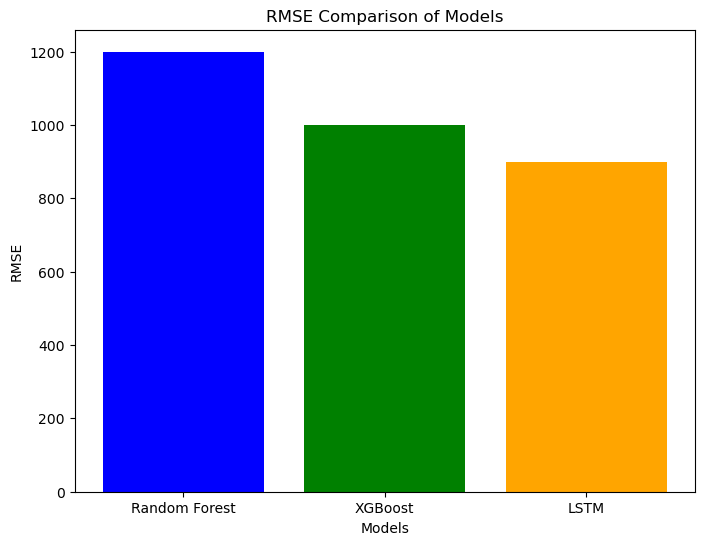

In [69]:
import matplotlib.pyplot as plt

# RMSE values from previous models
rf_rmse = 1200  # Replace with actual RMSE from Random Forest
xgb_rmse = 1000  # Replace with actual RMSE from XGBoost
lstm_rmse = 900  # Replace with actual RMSE from LSTM

# Dictionary to store RMSE results for each model
model_results = {
    'Random Forest': rf_rmse,
    'XGBoost': xgb_rmse,
    'LSTM': lstm_rmse
}

# Find the model with the lowest RMSE (best performance)
best_model = min(model_results, key=model_results.get)
print(f'The best performing model is: {best_model} with RMSE: {model_results[best_model]}')

# Plot the RMSE results for better visualization
models = list(model_results.keys())
rmse_values = list(model_results.values())

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.show()


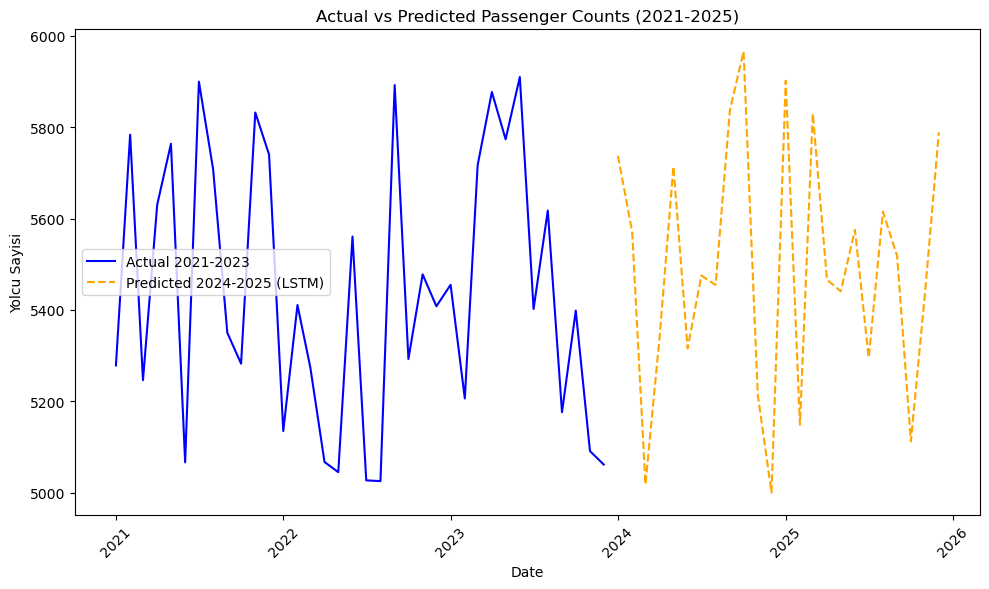

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import to_datetime

# Dummy data for predictions
# Replace this with actual predictions
dates_past = pd.date_range(start='2021-01-01', end='2023-12-01', freq='MS')
actual_values = np.random.rand(len(dates_past)) * 1000 + 5000  # Replace with actual data

dates_future = pd.date_range(start='2024-01-01', end='2025-12-01', freq='MS')
predicted_values = np.random.rand(len(dates_future)) * 1000 + 5000  # Replace with actual LSTM predictions

# Combine past actual data and future predicted data
dates_combined = np.concatenate((dates_past, dates_future))
values_combined = np.concatenate((actual_values, predicted_values))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dates_past, actual_values, label='Actual 2021-2023', color='blue')
plt.plot(dates_future, predicted_values, label='Predicted 2024-2025 (LSTM)', linestyle='--', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Yolcu Sayisi')
plt.title('Actual vs Predicted Passenger Counts (2021-2025)')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
